In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread

№1. Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из заданной вершины (Bellman–Ford). Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и номер стартовой вершины. Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [2]:
def bellman_ford(matrix, start_vertex):
    num_vertices = matrix.nrows
    distances = Vector(matrix.dtype, num_vertices)
    distances[start_vertex] << 0.0

    for _ in range(num_vertices - 1):
        new_distances = distances.dup()
        new_distances(binary.min) << distances.vxm(matrix, semiring.min_plus)

        if distances.isequal(new_distances):
            break
        distances = new_distances

    check_distances = distances.dup()
    check_distances(binary.min) << distances.vxm(matrix, semiring.min_plus)

    if not distances.isequal(check_distances):
        raise ValueError("Граф содержит цикл отрицательного веса")

    final_distances = np.full(num_vertices, float('inf'))
    indices, values = distances.to_coo()
    for index, value in zip(indices, values):
        final_distances[index] = value

    return final_distances

№2. Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из нескольких заданных вершин, модифицировав предыдущий алгоритм. Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин. Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [3]:
def bellman_ford_modify(matrix, start_vertex_ar):
    num_vertices = matrix.nrows
    num_start_vertices = len(start_vertex_ar)
    distances = Matrix(matrix.dtype, num_start_vertices, num_vertices)
    
    for i, start_vertex in enumerate(start_vertex_ar):
        distances[i, start_vertex] << 0.0

    for _ in range(num_vertices - 1):
        new_distances = distances.dup()
        for i in range(num_start_vertices):
            new_distances[i, :](binary.min) << distances[i, :].vxm(matrix, semiring.min_plus)

        if distances.isequal(new_distances):
            break
        distances = new_distances

    check_distances = distances.dup()
    for i in range(num_start_vertices):
        check_distances[i, :](binary.min) << distances[i, :].vxm(matrix, semiring.min_plus)

    if not distances.isequal(check_distances):
        raise ValueError("Граф содержит цикл отрицательного веса")

    output = {}
    for i, start_vertex in enumerate(start_vertex_ar):
        final_distances = np.full(num_vertices, float('inf'))
        indices, values = distances[i, :].to_coo()
        for index, value in zip(indices, values):
            final_distances[index] = value
        output[start_vertex] = final_distances

    return output

№3. Используя python-graphblas реализовать две функции поиска кратчайших путей в ориентированном графе для всех пар вершин (Floyd–Warshall и вычисление транзитивного замыкания). Функции принимают представление графа, удобное для неё (загрузка, конвертация реализованы отдельно). Функции возвращают массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [4]:
def floyd_warshall(matrix):
    num_vertices = matrix.nrows
    distances = matrix.dup()

    for k in range(num_vertices):
        cur_distances = distances.dup()
        D_col = Matrix(matrix.dtype, num_vertices, num_vertices)
        D_row = Matrix(matrix.dtype, num_vertices, num_vertices)
        D_col[:, k] = distances[:, k].dup()
        D_row[k, :] = distances[k, :].dup()
        cur_distances << D_col.mxm(D_row, semiring.min_plus)
        distances << distances.ewise_add(cur_distances, binary.min)
    check_distances = distances.dup()

    for k in range(num_vertices):
        D_col = Matrix(matrix.dtype, num_vertices, num_vertices)
        D_row = Matrix(matrix.dtype, num_vertices, num_vertices)
        D_col[:, k] = distances[:, k].dup()
        D_row[k, :] = distances[k, :].dup()
        cur_distances << D_col.mxm(D_row, semiring.min_plus)
        check_distances << check_distances.ewise_add(cur_distances, binary.min)
        if not check_distances.isequal(distances):
            raise ValueError("Граф содержит цикл отрицательного веса")

    output = {}
    for i in range(num_vertices):
        final_distances = np.full(num_vertices, float('inf'))
        for j in range(num_vertices):
            if i == j:
                final_distances[j] = 0
            elif distances[i, j].value is None:
                final_distances[j] = float('inf')
            else:
                final_distances[j] = distances[i, j].value
        output[i] = np.array(final_distances)

    return output

In [5]:
def transitive_closure(matrix):
    num_vertices = matrix.nrows
    I = Matrix(matrix.dtype, num_vertices, num_vertices)
    for i in range(num_vertices):
        I[i, i] << 1
    distances = I.dup()

    for _ in range(num_vertices):
        new_distances = distances.dup()
        distances << distances.mxm(matrix, semiring.min_plus).ewise_add(I, binary.min)
        
        if distances.isequal(new_distances):
            break

    check_distances = distances.dup()
    check_distances << check_distances.mxm(matrix, semiring.min_plus).ewise_add(I, binary.min)
    if not distances.isequal(check_distances):
        raise ValueError("Граф содержит цикл отрицательного веса")

    output = {}
    for i in range(num_vertices):
        final_distances = np.full(num_vertices, float('inf'))
        for j in range(num_vertices):
            if distances[i, j].value is None:
                final_distances[j] = float('inf')
            elif i == j:
                final_distances[j] = 0
            else:
                final_distances[j] = distances[i, j].value - 1
        output[i] = np.array(final_distances)

    return output

№4.  Добавить необходимые тесты.

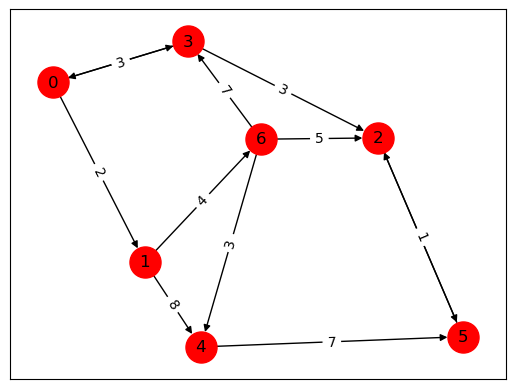

BellmanFord:
[14.  0.  9. 11.  7. 10.  4.]
[inf inf  0. inf inf  1. inf]
[ 3.  5.  3.  0. 12.  4.  9.]
BellmanFordModify:
{1: array([14.,  0.,  9., 11.,  7., 10.,  4.]), 2: array([inf, inf,  0., inf, inf,  1., inf]), 3: array([ 3.,  5.,  3.,  0., 12.,  4.,  9.])}
FloydWarshall:
{0: array([0., 2., 6., 3., 9., 7., 6.]), 1: array([14.,  0.,  9., 11.,  7., 10.,  4.]), 2: array([inf, inf,  0., inf, inf,  1., inf]), 3: array([ 3.,  5.,  3.,  0., 12.,  4.,  9.]), 4: array([inf, inf,  8., inf,  0.,  7., inf]), 5: array([inf, inf,  1., inf, inf,  0., inf]), 6: array([10., 12.,  5.,  7.,  3.,  6.,  0.])}
TransitiveClosure:
{0: array([0., 2., 6., 3., 9., 7., 6.]), 1: array([14.,  0.,  9., 11.,  7., 10.,  4.]), 2: array([inf, inf,  0., inf, inf,  1., inf]), 3: array([ 3.,  5.,  3.,  0., 12.,  4.,  9.]), 4: array([inf, inf,  8., inf,  0.,  7., inf]), 5: array([inf, inf,  1., inf, inf,  0., inf]), 6: array([10., 12.,  5.,  7.,  3.,  6.,  0.])}


In [6]:
import numpy as np
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]
rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)
gb.viz.draw(m)

#Для Беллман-Форда:
#При обходе из вершины 1: до 6 прямой путь кратчайший - 4; до 4 вершины из вариантов 1-6-4 и 1-4
#короче вариант 1-6-4, он равен 7; до нулевой вершины путь 1-6-3-0 длиной 14; до вершины 2
#путь 1-6-2 длиной 9; до вершины 3 путь 1-6-3 длиной 11, до вершины 5 короче будет путь 1-6-2-5 длиной 10.
print('BellmanFord:')
print(bellman_ford(m, 1))
#При обходе из вершины 2 достижима только вершина 5, путь длиной 1. Остальные вершины недостижимы.
print(bellman_ford(m, 2))
#При обходе из вершины 3: до 0 и 2 путь кратчайший прямой - длинами 3 и 3 соответственно; до 1 путь через 0
#длиной 5; до 6 самый короткий путь - 3-0-1-6 длиной 9; до 4 ближе будет через 6ку, вычисленную ранее - получится
#путь длиной 12; до 5ки путь через 2ку - длина 4.
print(bellman_ford(m, 3))
print('BellmanFordModify:')
print(bellman_ford_modify(m, np.array([1,2,3])))
print('FloydWarshall:')
print(floyd_warshall(m))
print('TransitiveClosure:')
print(transitive_closure(m))

In [7]:
#Поэлементная провекрка
assert (bellman_ford_modify(m, np.array([1,2,3]))[1]==bellman_ford(m, 1)).all()
assert (bellman_ford_modify(m, np.array([1,2,3]))[2]==bellman_ford(m, 2)).all()
assert (bellman_ford_modify(m, np.array([1,2,3]))[3]==bellman_ford(m, 3)).all()
assert (floyd_warshall(m)[1]==bellman_ford(m, 1)).all()
assert (floyd_warshall(m)[2]==bellman_ford(m, 2)).all()
assert (floyd_warshall(m)[3]==bellman_ford(m, 3)).all()
assert (floyd_warshall(m)[0]==transitive_closure(m)[0]).all()
assert (floyd_warshall(m)[1]==transitive_closure(m)[1]).all()
assert (floyd_warshall(m)[2]==transitive_closure(m)[2]).all()
assert (floyd_warshall(m)[3]==transitive_closure(m)[3]).all()
assert (floyd_warshall(m)[4]==transitive_closure(m)[4]).all()
assert (floyd_warshall(m)[5]==transitive_closure(m)[5]).all()
assert (floyd_warshall(m)[6]==transitive_closure(m)[6]).all()

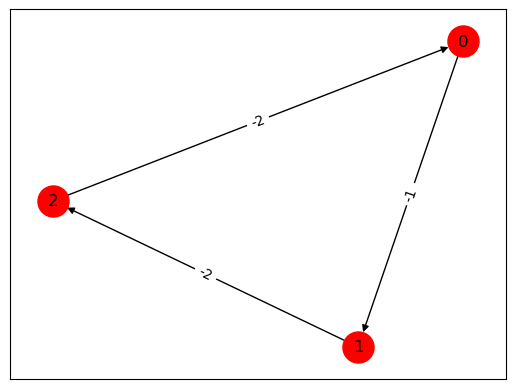

In [8]:
#Проверю функции на графе с циклом отрицательного веса (должны вернуть ошибку)
M1=gb.Matrix.from_coo(
    [0, 1, 2],
    [1, 2, 0],
    [-1,-2,-2],
    nrows=3,
    ncols=3
)
gb.viz.draw(M1)

In [9]:
try:
    bellman_ford(M1, 2)
except Exception as e:
    if str(e) == "Граф содержит цикл отрицательного веса":
        print("bellman_ford: Тест пройден")
    else:
        print(f"bellman_ford: Неверное сообщение об ошибке: {e}")
else:
    print("bellman_ford: Исключение не было вызвано")

bellman_ford: Тест пройден


In [10]:
try:
    bellman_ford_modify(M1, np.array([0,2]))
except Exception as e:
    if str(e) == "Граф содержит цикл отрицательного веса":
        print("bellman_ford_modify: Тест пройден")
    else:
        print(f"bellman_ford_modify: Неверное сообщение об ошибке: {e}")
else:
    print("bellman_ford_modify: Исключение не было вызвано")

bellman_ford_modify: Тест пройден


In [11]:
try:
    floyd_warshall(M1)
except Exception as e:
    if str(e) == "Граф содержит цикл отрицательного веса":
        print("floyd_warshall: Тест пройден")
    else:
        print(f"floyd_warshall: Неверное сообщение об ошибке: {e}")
else:
    print("floyd_warshall: Исключение не было вызвано")

floyd_warshall: Тест пройден


In [12]:
try:
    transitive_closure(M1)
except Exception as e:
    if str(e) == "Граф содержит цикл отрицательного веса":
        print("transitive_closure: Тест пройден")
    else:
        print(f"transitive_closure: Неверное сообщение об ошибке: {e}")
else:
    print("transitive_closure: Исключение не было вызвано")

transitive_closure: Тест пройден
